<a href="https://colab.research.google.com/github/ricacero/Datascience300/blob/main/Caso_Accidentes_NYC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ¿Cómo podemos controlar el creciente número de accidentes en Nueva York?

In [ ]:
import json
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy

## Introduccion

**Contexto empresarial.** La ciudad de Nueva York ha experimentado un aumento en el número de accidentes en las carreteras de la ciudad. Quieren saber si el número de accidentes ha aumentado en las últimas semanas. Para todos los accidentes reportados, han recopilado detalles para cada accidente y han estado manteniendo registros durante el último año y medio (desde enero de 2018 hasta agosto de 2019).

La ciudad te ha contratado para que construyas visualizaciones que les ayuden a identificar patrones en accidentes, lo que les ayudaría a tomar acciones preventivas para reducir la cantidad de accidentes en el futuro. Tienen ciertos parámetros como municipio, hora del día, motivo del accidente, etc. De los que se preocupan y de los que les gustaría obtener información específica.

**Problema comercial.** Su tarea es formatear los datos proporcionados y proporcionar visualizaciones que respondan las preguntas específicas que tiene el cliente, que se mencionan a continuación.

**Contexto analítico.** Se le proporciona un archivo CSV (almacenado en la carpeta ```datos``` ya creada) que contiene detalles sobre cada accidente, como fecha, hora, ubicación del accidente, motivo del accidente, tipos de vehículos involucrados, recuento de lesiones y muertes, etc. El delimitador en el archivo CSV dado es `;` en lugar del predeterminado `,`. Realizará las siguientes tareas con los datos:

1. Extraiga datos adicionales del municipio almacenados en un archivo JSON
2. Leer, transformar y preparar datos para su visualización
3. Realizar análisis y construir visualizaciones de los datos para identificar patrones en el conjunto de datos.
        
El cliente tiene un conjunto específico de preguntas a las que le gustaría obtener respuestas. Deberá proporcionar visualizaciones para acompañar estos:

1. ¿Cómo ha fluctuado el número de accidentes durante el último año y medio? ¿Han aumentado con el tiempo?
2. Para un día en particular, ¿durante qué horas es más probable que ocurran accidentes?
3. ¿Hay más accidentes entre semana que durante los fines de semana?
4. ¿Cuál es la proporción de recuento de accidentes por área por municipio? ¿Qué distritos tienen un número desproporcionadamente grande de accidentes para su tamaño?
5. Para cada municipio, ¿durante qué horas es más probable que ocurran accidentes?
6. ¿Cuáles son las 5 principales causas de accidentes en la ciudad?
7. ¿Qué tipos de vehículos están más involucrados en accidentes por municipio?
8. ¿Qué tipos de vehículos están más involucrados en las muertes?

## Obteniendo los datos relevantes

El cliente ha solicitado un análisis de la relación accidentes-área de los distritos. Los datos del municipio se almacenan en un archivo JSON en la carpeta ```datos```.

### Pregunta 

Utilice la función ```json.load()``` para cargar el archivo ```borough_data.json``` como diccionario.

**Respuesta.** 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Pregunta 
De manera similar, use la función pandas ```read_csv()``` para cargar el archivo ```accidentes.csv``` como un DataFrame. Nombra este DataFrame ```df```.


In [ ]:
%cd '/content/drive/MyDrive/Caso NYC'

/content/drive/MyDrive/Caso NYC


In [51]:
with open('data/borough_data.json') as f:
    borough_data=json.load(f)
    
borough_data

{'brooklyn': {'area': 70.82, 'name': 'brooklyn', 'population': 2648771.0},
 'manhattan': {'area': 22.83, 'name': 'manhattan', 'population': 1664727.0},
 'queens': {'area': 108.53, 'name': 'queens', 'population': 2358582.0},
 'staten island': {'area': 58.37,
  'name': 'staten island',
  'population': 479458.0},
 'the bronx': {'area': 42.1, 'name': 'the bronx', 'population': 1471160.0}}

**Respuesta.** 

In [ ]:
with open('data/accidents.csv') as f:
    df=pd.read_csv(f, delimiter=';')

In [ ]:
df=pd.read_csv('data/accidents.csv',delimiter=";")
df

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,ON STREET NAME,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,09/26/2018,12:12,BRONX,10454.0,40.808987,-73.911316,NaN,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,3988123,Sedan,NaN,NaN,NaN,NaN
1,09/25/2018,16:30,BROOKLYN,11236.0,40.636005,-73.912510,FLATLANDS AVENUE,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,3987962,Sedan,NaN,NaN,NaN,NaN
2,08/22/2019,19:30,QUEENS,11101.0,40.755490,-73.939530,NaN,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4193132,Sedan,NaN,NaN,NaN,NaN
3,09/23/2018,13:10,QUEENS,11367.0,NaN,NaN,MAIN STREET,0,0,1,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,3985962,Bike,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
4,08/20/2019,22:40,BRONX,10468.0,40.868336,-73.901270,NaN,0,0,0,0,1,0,View Obstructed/Limited,Unspecified,NaN,NaN,NaN,4192111,Sedan,Sedan,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238517,01/20/2018,15:00,QUEENS,11436.0,40.685356,-73.797230,LINDEN BOULEVARD,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,3832275,SPORT UTILITY / STATION WAGON,PASSENGER VEHICLE,NaN,NaN,NaN
238518,01/04/2018,14:00,BRONX,10452.0,40.845180,-73.914170,JEROME AVENUE,0,0,0,0,0,0,Pavement Slippery,NaN,NaN,NaN,NaN,3822315,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,NaN
238519,01/20/2018,13:05,BRONX,10462.0,40.831210,-73.850876,CASTLE HILL AVENUE,0,0,0,0,0,0,Unsafe Lane Changing,Unspecified,NaN,NaN,NaN,3832513,PASSENGER VEHICLE,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN
238520,01/29/2018,17:45,QUEENS,11377.0,40.757250,-73.904854,31 AVENUE,0,0,0,0,2,0,Failure to Yield Right-of-Way,Unspecified,NaN,NaN,NaN,3837608,SPORT UTILITY / STATION WAGON,PASSENGER VEHICLE,NaN,NaN,NaN


## Overview de la data

Analizemos las columnas presentes en el data frame

In [ ]:
df.columns

Index(['DATE', 'TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
       'ON STREET NAME', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5'],
      dtype='object')

Tenemos las siguientes columnas

1. **BOROUGH**: el municipio en el que ocurrió el accidente
2. **COLLISION_ID**: un identificador único para esta colisión
3. **CONTRIBUTING FACTOR VEHICLE (1, 2, 3, 4, 5)**: Motivos del accidente
4. **CROSS STREET NAME**: Calle transversal más cercana al lugar del accidente
5. **DATE**: Fecha del accidente
6. **TIME**: Hora del accidente
7. **LATITUDE**: Latitud del accidente
8. **LONGITUDE**: Longitud del accidente
9. **NUMBER OF (CYCLISTS, MOTORISTS, PEDESTRIANS) INJURED**: Lesión por categoría
10. **NUMBER OF (CYCLISTS, MOTORISTS, PEDESTRIANS) DEATHS**: Categoría muerte sabia
11. **ON STREET NAME**: Calle donde ocurrió el accidente
13. **VEHICLE TYPE CODE(1, 2, 3, 4, 5)**: Tipos de vehículos involucrados en el accidente
14. **ZIP CODE**: código postal del lugar del accidente

### Ejercicio 1

Desde 2014, la ciudad de Nueva York ha estado implementando un plan de seguridad vial llamado [Vision Zero](https://www1.nyc.gov/content/visionzero/pages/). Su objetivo es reducir el número de muertes por accidentes de tránsito a *cero* para fines de 2024. El plan está creando nuevas y mejorando las medidas de seguridad actuales, algunas de ellas incluyen:

- [ ] Detección de peatones automatizada
- [ ] Auditorías de seguridad vial en lugares de alto riesgo
- [ ] Ampliación de la red de carriles bici
- [ ] Iniciativas específicas de educación y sensibilización
- [ ] Creación de islas de refugio peatonal
- [ ] Lanzamiento del programa integrado de reductor de velocidad basado en datos (topes y amortiguadores de velocidad)

¿Cuáles de estas iniciativas podrían beneficiarse directamente de un análisis de los datos proporcionados? Marque todo lo que corresponda.

**Nota:** Puede crear marcas de verificación haciendo doble clic en esta celda y agregando una ```[x]``` en las líneas correspondientes.

**Respuesta.**

- [ ] Detecciòn de peatones automatizada


- [ ] Auditorías de seguridadvial en lugares de alto riesgo

- [ ] Ampliación de la red de carriles bici

- [ ] Iniciativas especificas de educación y sensibilización

- [ ] Creación de islas de refugio peatonal

- [ ] Lanzamiento del programa integrado de reductor de velocidad en datos (topes y amortiguadores de velocidad)


Sigamos adelante y respondamos a cada una de las preguntas del cliente.

## Respondiendo las preguntas del cliente 

### Ejercicio 2 

Agrupe los datos disponibles mensualmente y genere un line plot de accidentes a lo largo del tiempo. ¿Ha aumentado el número de accidentes durante el último año y medio?

**Sugerencia**: Puede encontrar útiles las funciones de pandas ```to_datetime ()``` y ```dt.to_period ()```.

**Respuesta.** 

Si ha habido una disminución de accidentalidad en el ultimo año y medio

Text(0.5, 1.0, 'Evolucion de Accidentes NYC')

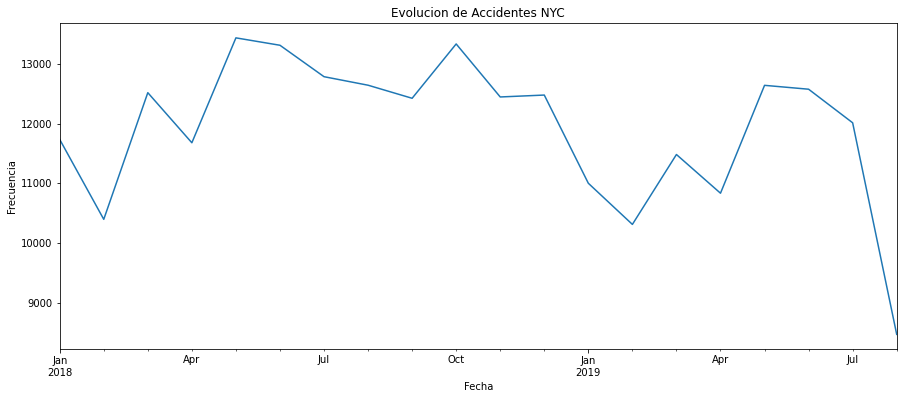

In [ ]:

df['DATE']=pd.to_datetime(df['DATE'])
monthly_accidents =df.groupby(df['DATE'].dt.to_period('M')).size()
plt.figure(figsize=(15,6))
monthly_accidents.plot.line()
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.title('Evolucion de Accidentes NYC')

Text(0.5, 1.0, 'Evolucion de Accidentes NYC x Meses')

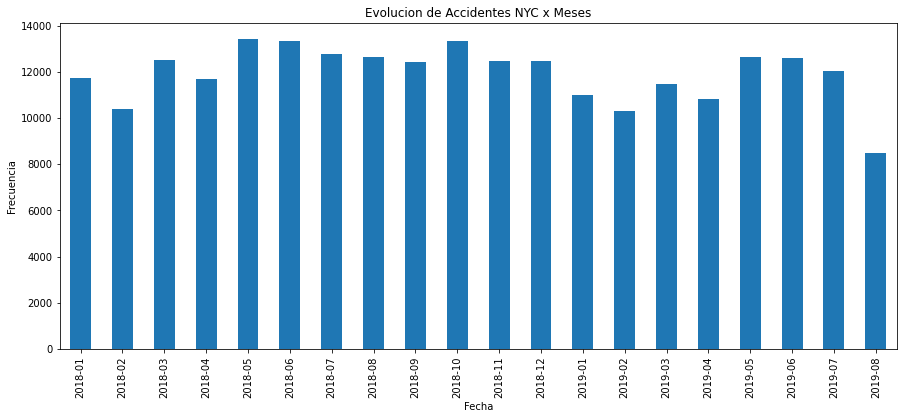

In [ ]:
df['DATE']=pd.to_datetime(df['DATE'])
monthly_accidents =df.groupby(df['DATE'].dt.to_period('M')).size()
plt.figure(figsize=(15,6))
monthly_accidents.plot.bar()
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.title('Evolucion de Accidentes NYC x Meses')


In [ ]:
dft= pd.DataFrame()
dft['Accidentes']= monthly_accidents
dft['Fecha']=dft.index
dft=dft.reset_index()
dft

,DATE,Accidentes,Fecha
0,2018-01,11735,2018-01
1,2018-02,10395,2018-02
2,2018-03,12519,2018-03
3,2018-04,11679,2018-04
4,2018-05,13438,2018-05
5,2018-06,13314,2018-06
6,2018-07,12787,2018-07
7,2018-08,12644,2018-08
8,2018-09,12425,2018-09
9,2018-10,13336,2018-10


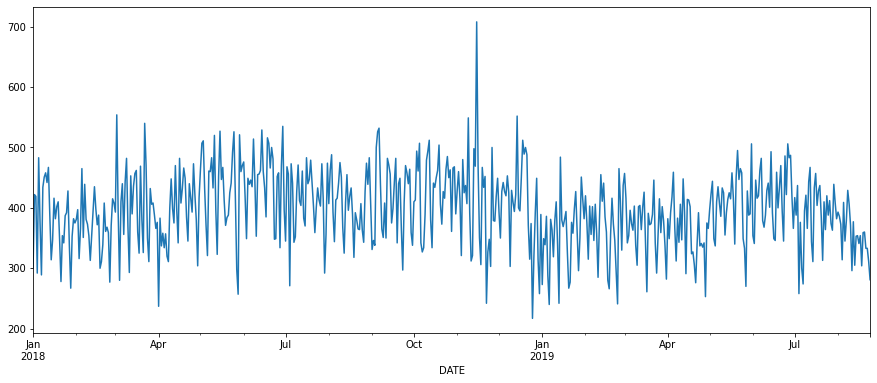

In [ ]:
df['DATE']=pd.to_datetime(df['DATE']) # Formato datetime python 
monthly_accidents =df.groupby(df['DATE'].dt.to_period('D')).size()
plt.figure(figsize=(15,6))
monthly_accidents.plot.line()

In [ ]:
dft= pd.DataFrame()
dft['Accidentes']= monthly_accidents
dft['Fecha']=dft.index
dft=dft.reset_index()
dft

,DATE,Accidentes,Fecha
0,2018-01-01,301,2018-01-01
1,2018-01-02,422,2018-01-02
2,2018-01-03,419,2018-01-03
3,2018-01-04,292,2018-01-04
4,2018-01-05,483,2018-01-05
...,...,...,...
596,2019-08-20,360,2019-08-20
597,2019-08-21,333,2019-08-21
598,2019-08-22,333,2019-08-22
599,2019-08-23,311,2019-08-23


### Ejercicio 3

De la gráfica anterior, ¿qué meses parecen tener el menor número de accidentes? ¿Cuáles crees que son las razones detrás de esto?

**Respuesta.** 


Los meses con menos accidentalidad son el mes de febrero tanto del 2018 y 2019, pero hay que tener en cuenta que estos son dos meses de 28 días comparados con los demás, le siguen abril del 2019 y enero de 2019 que tienen 31 días cada uno y es un dato más confiable. Pensaría que la accidentalidad puede estar relacionada con las estaciones, en los meses de invierno tiende a disminuir comparado con los de verano, pero es muy relativo. El mes de Agosto de 2019 no es comparable porque hay solo datos hasta el 24 de ese mes por lo que faltarían datos de 7 días por eso no lo tengo en cuenta.

### Ejercicio 4 
¿Cómo varía el número de accidentes a lo largo de un solo día? Cree una nueva columna `HOUR` basada en los datos de la columna `TIME`, luego trace un gráfico de barras de la distribución por hora a lo largo del día.

**Sugerencia:** Puede encontrar útil la función ```dt.hour```.

**Respuesta.**

Segun la grafica podriamos decir que la accidentalidad es baja en horas de la noche, se puede intuir que no hay tantas personas afuera, y tambien se visualiza un ascenso en los accidentes a la hora de regreso a casa desde las 4 a 6 y alta accidentalidad en horas de la mañana cuando se presume van al trabajo.

In [ ]:
import datetime as dt
df['TIME']=pd.to_datetime(df['TIME'])
df['HOUR'] = df['TIME'].dt.hour
df

,DATE,TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,ON STREET NAME,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,HOUR
0,2018-09-26,2022-01-10 12:12:00,BRONX,10454.0,40.808987,-73.911316,NaN,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,3988123,Sedan,NaN,NaN,NaN,NaN,12
1,2018-09-25,2022-01-10 16:30:00,BROOKLYN,11236.0,40.636005,-73.912510,FLATLANDS AVENUE,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,3987962,Sedan,NaN,NaN,NaN,NaN,16
2,2019-08-22,2022-01-10 19:30:00,QUEENS,11101.0,40.755490,-73.939530,NaN,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4193132,Sedan,NaN,NaN,NaN,NaN,19
3,2018-09-23,2022-01-10 13:10:00,QUEENS,11367.0,NaN,NaN,MAIN STREET,0,0,1,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,3985962,Bike,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN,13
4,2019-08-20,2022-01-10 22:40:00,BRONX,10468.0,40.868336,-73.901270,NaN,0,0,0,0,1,0,View Obstructed/Limited,Unspecified,NaN,NaN,NaN,4192111,Sedan,Sedan,NaN,NaN,NaN,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238517,2018-01-20,2022-01-10 15:00:00,QUEENS,11436.0,40.685356,-73.797230,LINDEN BOULEVARD,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,3832275,SPORT UTILITY / STATION WAGON,PASSENGER VEHICLE,NaN,NaN,NaN,15
238518,2018-01-04,2022-01-10 14:00:00,BRONX,10452.0,40.845180,-73.914170,JEROME AVENUE,0,0,0,0,0,0,Pavement Slippery,NaN,NaN,NaN,NaN,3822315,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,NaN,14
238519,2018-01-20,2022-01-10 13:05:00,BRONX,10462.0,40.831210,-73.850876,CASTLE HILL AVENUE,0,0,0,0,0,0,Unsafe Lane Changing,Unspecified,NaN,NaN,NaN,3832513,PASSENGER VEHICLE,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,13
238520,2018-01-29,2022-01-10 17:45:00,QUEENS,11377.0,40.757250,-73.904854,31 AVENUE,0,0,0,0,2,0,Failure to Yield Right-of-Way,Unspecified,NaN,NaN,NaN,3837608,SPORT UTILITY / STATION WAGON,PASSENGER VEHICLE,NaN,NaN,NaN,17


In [ ]:
df = df[['DATE', 'TIME','HOUR', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
       'ON STREET NAME', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       ]]

In [ ]:
df

,DATE,TIME,HOUR,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,ON STREET NAME,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5
0,2018-09-26,2022-01-10 12:12:00,12,BRONX,10454.0,40.808987,-73.911316,NaN,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,3988123,Sedan,NaN,NaN,NaN,NaN
1,2018-09-25,2022-01-10 16:30:00,16,BROOKLYN,11236.0,40.636005,-73.912510,FLATLANDS AVENUE,1,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,3987962,Sedan,NaN,NaN,NaN,NaN
2,2019-08-22,2022-01-10 19:30:00,19,QUEENS,11101.0,40.755490,-73.939530,NaN,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4193132,Sedan,NaN,NaN,NaN,NaN
3,2018-09-23,2022-01-10 13:10:00,13,QUEENS,11367.0,NaN,NaN,MAIN STREET,0,0,1,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,3985962,Bike,Station Wagon/Sport Utility Vehicle,NaN,NaN,NaN
4,2019-08-20,2022-01-10 22:40:00,22,BRONX,10468.0,40.868336,-73.901270,NaN,0,0,0,0,1,0,View Obstructed/Limited,Unspecified,NaN,NaN,NaN,4192111,Sedan,Sedan,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238517,2018-01-20,2022-01-10 15:00:00,15,QUEENS,11436.0,40.685356,-73.797230,LINDEN BOULEVARD,0,0,0,0,0,0,Driver Inattention/Distraction,Unspecified,NaN,NaN,NaN,3832275,SPORT UTILITY / STATION WAGON,PASSENGER VEHICLE,NaN,NaN,NaN
238518,2018-01-04,2022-01-10 14:00:00,14,BRONX,10452.0,40.845180,-73.914170,JEROME AVENUE,0,0,0,0,0,0,Pavement Slippery,NaN,NaN,NaN,NaN,3822315,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN,NaN
238519,2018-01-20,2022-01-10 13:05:00,13,BRONX,10462.0,40.831210,-73.850876,CASTLE HILL AVENUE,0,0,0,0,0,0,Unsafe Lane Changing,Unspecified,NaN,NaN,NaN,3832513,PASSENGER VEHICLE,SPORT UTILITY / STATION WAGON,NaN,NaN,NaN
238520,2018-01-29,2022-01-10 17:45:00,17,QUEENS,11377.0,40.757250,-73.904854,31 AVENUE,0,0,0,0,2,0,Failure to Yield Right-of-Way,Unspecified,NaN,NaN,NaN,3837608,SPORT UTILITY / STATION WAGON,PASSENGER VEHICLE,NaN,NaN,NaN


Text(0.5, 1.0, 'Accidentes hora en el dia')

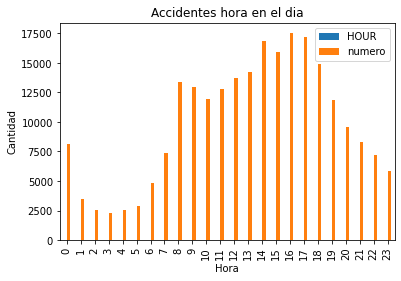

In [ ]:
HA=df.groupby(['HOUR']).size().reset_index(name='numero')
HA.plot.bar()
plt.xlabel('Hora')
plt.ylabel('Cantidad')
plt.title('Accidentes hora en el dia')



In [ ]:
df.groupby(['HOUR']).size().reset_index(name='numero')

,HOUR,numero
0,0,8160
1,1,3460
2,2,2570
3,3,2302
4,4,2562
5,5,2878
6,6,4844
7,7,7399
8,8,13403
9,9,12939


### Ejercicio 5 

En la pregunta anterior hemos agregado el número de accidentes por hora sin tener en cuenta la fecha y el lugar en que ocurrieron. ¿Qué crítica le daría a este enfoque?

**Respuesta.** 


Para una mejor precisión debemos saber el lugar en donde ocurrieron, hay barrios que según los datos tienen mas trafico y afluencia de personas que otros, también como sabemos que los accidentes aumentan dependiendo del clima la estación en que nos encontremos eso se debe tener en cuenta.

### Ejercicio 6 

¿Cómo varía el número de accidentes en una sola semana? Trace un gráfico de barras basado en el recuento de accidentes por día de la semana.

**Sugerencia:** Puede encontrar útil la función ```dt.weekday```.

**Respuesta.**

Podemos visualizar que los dias con mas accidentalidad es el dia viernes, y lo que menos tienen son el dia Domingo y el sabado.

Text(0.5, 1.0, 'Evolucion de Accidentes NYC x Meses')

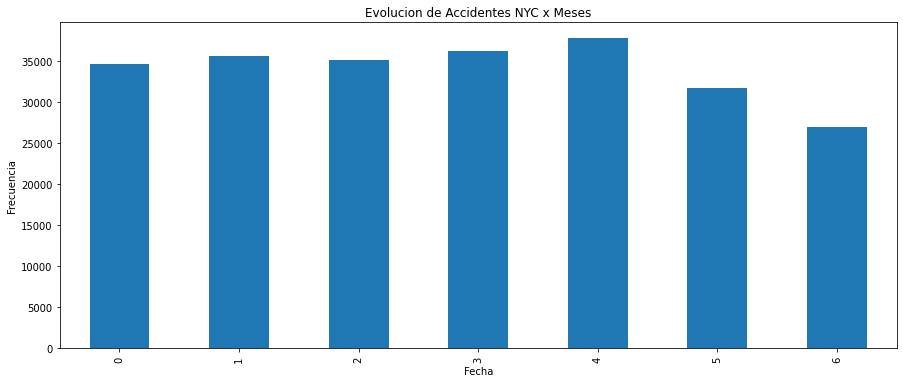

In [ ]:
df['DATE']=pd.to_datetime(df['DATE'])
WA =df.groupby(df['DATE'].dt.weekday).size()
plt.figure(figsize=(15,6))
WA.plot.bar()
plt.xlabel('Fecha')
plt.ylabel('Frecuencia')
plt.title('Evolucion de Accidentes NYC x Meses')

In [42]:
df.groupby(df['DATE'].dt.weekday).size().reset_index(name='numero')

,DATE,numero
0,0,34719
1,1,35651
2,2,35188
3,3,36254
4,4,37886
5,5,31784
6,6,27040


### Ejercicio 7

Trace una gráfica de barras del número total de accidentes en cada municipio, así como uno de los accidentes por milla cuadrada por municipio. ¿Qué puedes concluir?

**Sugerencia:** Es posible que desee actualizar algunas de las claves en el diccionario del municipio para que coincidan con los nombres en el marco de datos.

**Respuesta.**

Se puede concluir que en el municipio de Manhattan es el de mas accidentalidad con respecto al area que maneja, y el de menor accidentalidad es el municipio de STATEN ISLAND respecto al area que tiene.


In [41]:
df['BOROUGH'].unique()

array(['BRONX', 'BROOKLYN', 'QUEENS', 'MANHATTAN', 'STATEN ISLAND'],
      dtype=object)

In [52]:
borough_data

{'brooklyn': {'area': 70.82, 'name': 'brooklyn', 'population': 2648771.0},
 'manhattan': {'area': 22.83, 'name': 'manhattan', 'population': 1664727.0},
 'queens': {'area': 108.53, 'name': 'queens', 'population': 2358582.0},
 'staten island': {'area': 58.37,
  'name': 'staten island',
  'population': 479458.0},
 'the bronx': {'area': 42.1, 'name': 'the bronx', 'population': 1471160.0}}

In [ ]:
df['BOROUGH'].unique()

array(['BRONX', 'BROOKLYN', 'QUEENS', 'MANHATTAN', 'STATEN ISLAND'],
      dtype=object)

In [55]:
borough_data.update({
 'BRONX': {'area': 42.1, 'name': 'BRONX', 'population': 1471160.0}})
del borough_data[ 'the bronx']

In [56]:
borough_data

{'BRONX': {'area': 42.1, 'name': 'BRONX', 'population': 1471160.0},
 'brooklyn': {'area': 70.82, 'name': 'brooklyn', 'population': 2648771.0},
 'manhattan': {'area': 22.83, 'name': 'manhattan', 'population': 1664727.0},
 'queens': {'area': 108.53, 'name': 'queens', 'population': 2358582.0},
 'staten island': {'area': 58.37,
  'name': 'staten island',
  'population': 479458.0}}

In [60]:
df1 = pd.DataFrame([key for key in borough_data.keys()], columns=['BOROUGH'])
df1['area'] = [value['area'] for value in borough_data.values()]
df1['name'] = [value['name'] for value in borough_data.values()]
df1['population'] = [value['population'] for value in borough_data.values()]
df1


,BOROUGH,area,name,population
0,brooklyn,70.82,brooklyn,2648771.0
1,manhattan,22.83,manhattan,1664727.0
2,queens,108.53,queens,2358582.0
3,staten island,58.37,staten island,479458.0
4,BRONX,42.10,BRONX,1471160.0


In [64]:
df1 ['BOROUGH'] = df1 ['BOROUGH']. str.upper ()
df1

,BOROUGH,area,name,population
0,BROOKLYN,70.82,brooklyn,2648771.0
1,MANHATTAN,22.83,manhattan,1664727.0
2,QUEENS,108.53,queens,2358582.0
3,STATEN ISLAND,58.37,staten island,479458.0
4,BRONX,42.10,BRONX,1471160.0


In [66]:
merged_df = pd.merge(left=df,right=df1, left_on='BOROUGH', right_on='BOROUGH')
merged_df

,DATE,TIME,HOUR,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,ON STREET NAME,NUMBER OF PEDESTRIANS INJURED,NUMBER OF PEDESTRIANS KILLED,NUMBER OF CYCLIST INJURED,NUMBER OF CYCLIST KILLED,NUMBER OF MOTORIST INJURED,NUMBER OF MOTORIST KILLED,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,COLLISION_ID,VEHICLE TYPE CODE 1,VEHICLE TYPE CODE 2,VEHICLE TYPE CODE 3,VEHICLE TYPE CODE 4,VEHICLE TYPE CODE 5,area,name,population
0,2018-09-26,2022-01-10 12:12:00,12,BRONX,10454.0,40.808987,-73.911316,NaN,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,3988123,Sedan,NaN,NaN,NaN,NaN,42.10,BRONX,1471160.0
1,2019-08-20,2022-01-10 22:40:00,22,BRONX,10468.0,40.868336,-73.901270,NaN,0,0,0,0,1,0,View Obstructed/Limited,Unspecified,NaN,NaN,NaN,4192111,Sedan,Sedan,NaN,NaN,NaN,42.10,BRONX,1471160.0
2,2018-09-22,2022-01-10 11:25:00,11,BRONX,10465.0,40.836227,-73.822920,NaN,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,4004118,Sedan,NaN,NaN,NaN,NaN,42.10,BRONX,1471160.0
3,2018-09-22,2022-01-10 15:56:00,15,BRONX,10451.0,40.819298,-73.921880,NaN,0,0,0,0,0,0,Unspecified,NaN,NaN,NaN,NaN,3985745,Sedan,NaN,NaN,NaN,NaN,42.10,BRONX,1471160.0
4,2019-08-18,2022-01-10 12:43:00,12,BRONX,10451.0,NaN,NaN,EAST 149 STREET,0,0,0,0,0,0,Driver Inexperience,Passing Too Closely,NaN,NaN,NaN,4191092,Sedan,Sedan,NaN,NaN,NaN,42.10,BRONX,1471160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238517,2018-01-05,2022-01-10 16:20:00,16,STATEN ISLAND,10312.0,40.548103,-74.183560,ARDEN AVENUE,0,0,0,0,0,0,Unsafe Speed,Unspecified,NaN,NaN,NaN,3823750,SPORT UTILITY / STATION WAGON,PASSENGER VEHICLE,NaN,NaN,NaN,58.37,staten island,479458.0
238518,2018-01-07,2022-01-10 15:20:00,15,STATEN ISLAND,10306.0,40.571040,-74.109190,HYLAN BOULEVARD,0,0,0,0,0,0,Following Too Closely,Unspecified,NaN,NaN,NaN,3823913,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN,58.37,staten island,479458.0
238519,2018-01-17,2022-01-10 14:46:00,14,STATEN ISLAND,10305.0,40.579792,-74.078865,NaN,0,0,0,0,0,0,Failure to Yield Right-of-Way,Unspecified,NaN,NaN,NaN,3831058,SPORT UTILITY / STATION WAGON,PASSENGER VEHICLE,NaN,NaN,NaN,58.37,staten island,479458.0
238520,2018-01-20,2022-01-10 12:33:00,12,STATEN ISLAND,10305.0,40.607120,-74.066840,NaN,0,0,0,0,0,0,Passing Too Closely,Unspecified,NaN,NaN,NaN,3833047,PASSENGER VEHICLE,PASSENGER VEHICLE,NaN,NaN,NaN,58.37,staten island,479458.0


In [67]:
merged_df.columns

Index(['DATE', 'TIME', 'HOUR', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE',
       'ON STREET NAME', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'area', 'name', 'population'],
      dtype='object')

,,accidentes
BOROUGH,area,
BRONX,42.10,37709
BROOKLYN,70.82,76253
MANHATTAN,22.83,48749
QUEENS,108.53,67120
STATEN ISLAND,58.37,8691


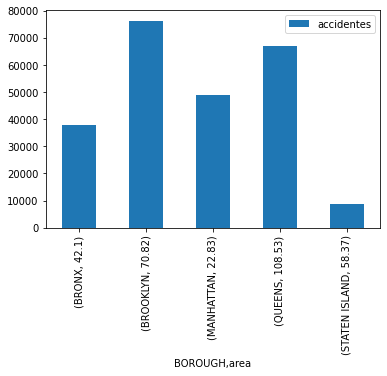

In [87]:
BA=pd.DataFrame({'accidentes': merged_df.groupby(['BOROUGH','area']).size()})
BA.plot.bar()
BA

In [86]:
BA.sum()

accidentes    238522
dtype: int64

### Ejercicio 8 

¿Qué horas tienen más accidentes en cada municipio? Trace un gráfico de barras para cada municipio que muestre el número de accidentes por cada hora del día.

**Sugerencia:** Puede usar ```sns.FacetGrid``` para crear una cuadrícula de parcelas con los datos por hora de cada municipio.

**Respuesta.**

In [93]:
df3 = pd.DataFrame({'count': df.groupby(['BOROUGH', 'HOUR']).size()})
df3 = df3.reset_index()
df3

,BOROUGH,HOUR,count
0,BRONX,0,1329
1,BRONX,1,529
2,BRONX,2,402
3,BRONX,3,361
4,BRONX,4,418
...,...,...,...
115,STATEN ISLAND,19,415
116,STATEN ISLAND,20,367
117,STATEN ISLAND,21,268
118,STATEN ISLAND,22,224


/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


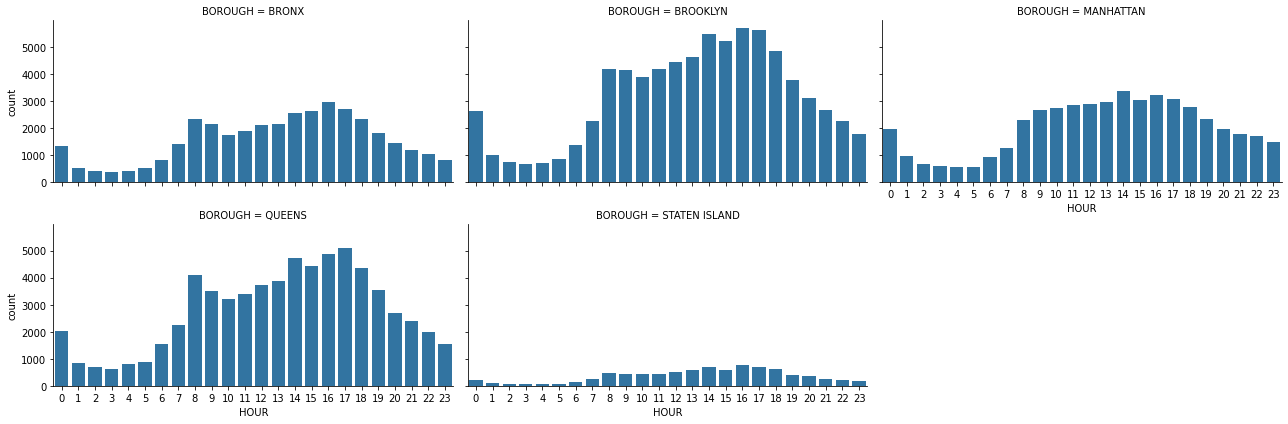

In [92]:
chart = sns.FacetGrid(df3, col='BOROUGH', margin_titles=True, col_wrap=3, aspect=2, row_order=df['BOROUGH'].unique)
chart
chart.map(sns.barplot, 'HOUR', 'count')

**¿Es mayor el número de accidentes en diferentes momentos en diferentes distritos? ¿Deberíamos concentrarnos en diferentes momentos para cada municipio?**

En lso municipios de Broklyn, Bronx y Staten Island la hora con mas accidentalidad es las 16 horas, en MAN es las 14 horas y en QUEENS las 17 horas, pero en todos los municipios manejan la mas alta accidentalidad desde las 14 horas hasta las 18 horas. 

### Ejercicio 9 

¿Qué factores provocan la mayoría de los accidentes? Evite contar dos veces los factores que contribuyen a un solo accidente.

**Sugerencia:** Una forma de lidiar con las repeticiones es concatenar las columnas correspondientes conservando sus índices, puede hacerlo con las funciones ```pd.concat()``` y ```reset_index()```. Luego, use un ```group_by``` apropiado para contar el número de repeticiones de factores contribuidos por accidente.

**Respuesta**.


Los siguientes son los factores que provocan la mayoria de accidentes:

Driver Inattention/Distraction                           
Failure to Yield Right-of-Way                            
Following Too Closely                                   
Backing Unsafely                                        
Passing Too Closely                                     
Passing or Lane Usage Improper 

In [126]:
merged_df.value_counts(['CONTRIBUTING FACTOR VEHICLE 1'])

CONTRIBUTING FACTOR VEHICLE 1                        
Unspecified                                              59307
Driver Inattention/Distraction                           58551
Failure to Yield Right-of-Way                            18236
Following Too Closely                                    15370
Backing Unsafely                                         13876
Passing Too Closely                                      11337
Passing or Lane Usage Improper                           10469
Other Vehicular                                           7509
Turning Improperly                                        6043
Unsafe Lane Changing                                      5932
Traffic Control Disregarded                               4320
Driver Inexperience                                       3799
Unsafe Speed                                              2828
Reaction to Uninvolved Vehicle                            2786
Alcohol Involvement                                       2382
V

In [125]:
merged_df.isna().sum()

DATE                                  0
TIME                                  0
HOUR                                  0
BOROUGH                               0
ZIP CODE                             70
LATITUDE                           6978
LONGITUDE                          6978
ON STREET NAME                    84604
NUMBER OF PEDESTRIANS INJURED         0
NUMBER OF PEDESTRIANS KILLED          0
NUMBER OF CYCLIST INJURED             0
NUMBER OF CYCLIST KILLED              0
NUMBER OF MOTORIST INJURED            0
NUMBER OF MOTORIST KILLED             0
CONTRIBUTING FACTOR VEHICLE 1       884
CONTRIBUTING FACTOR VEHICLE 2     40008
CONTRIBUTING FACTOR VEHICLE 3    225450
CONTRIBUTING FACTOR VEHICLE 4    235666
CONTRIBUTING FACTOR VEHICLE 5    237730
COLLISION_ID                          0
VEHICLE TYPE CODE 1                1721
VEHICLE TYPE CODE 2               55590
VEHICLE TYPE CODE 3              226221
VEHICLE TYPE CODE 4              235806
VEHICLE TYPE CODE 5              237769


In [118]:
merged_df.groupby(['CONTRIBUTING FACTOR VEHICLE 1','CONTRIBUTING FACTOR VEHICLE 2','CONTRIBUTING FACTOR VEHICLE 3','CONTRIBUTING FACTOR VEHICLE 4','CONTRIBUTING FACTOR VEHICLE 5']).size().reset_index(name='numero')

,CONTRIBUTING FACTOR VEHICLE 1,CONTRIBUTING FACTOR VEHICLE 2,CONTRIBUTING FACTOR VEHICLE 3,CONTRIBUTING FACTOR VEHICLE 4,CONTRIBUTING FACTOR VEHICLE 5,numero
0,Accelerator Defective,Unspecified,Unspecified,Unspecified,Unspecified,4
1,Aggressive Driving/Road Rage,Following Too Closely,Unspecified,Unspecified,Unspecified,1
2,Aggressive Driving/Road Rage,Unspecified,Unspecified,Unspecified,Unspecified,19
3,Alcohol Involvement,Alcohol Involvement,Oversized Vehicle,Unspecified,Unspecified,1
4,Alcohol Involvement,Alcohol Involvement,Unspecified,Unspecified,Unspecified,1
...,...,...,...,...,...,...
103,Unsafe Speed,Unsafe Speed,Unspecified,Unspecified,Unspecified,3
104,Unsafe Speed,Unspecified,Unspecified,Unspecified,Unspecified,90
105,Unsafe Speed,View Obstructed/Limited,Unspecified,Unspecified,Unspecified,1
106,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,85


### Ejercicio 10 

¿Qué tipos de vehículos están más involucrados en accidentes por municipio? Evite contar dos veces el tipo de vehículos presentes en un solo accidente.

**Sugerencia:** Puede aplicar un enfoque similar al utilizado en la pregunta anterior.

**Respuesta.** 

Los vehiculos mas involucrados por municipio son SEDAN, Station Wagon/Sport Utility Vehicle y PASSENGER VEHICLE

In [127]:
data_crosstab = pd.crosstab(merged_df['BOROUGH'],
                            merged_df['VEHICLE TYPE CODE 1'], 
                               margins = True)
data_crosstab

VEHICLE TYPE CODE 1,(ceme,12 Pa,15 Pa,2 TON,3 WHE,3-Door,3D,4 dr sedan,4whee,99999,ACCES,AM,AMB,AMBU,AMBUL,AMBULANCE,AMbul,APPOR,AR,ARMOR,Acces,Ambul,Ambulance,Armored Truck,BA,BACK,BACKH,BICYCLE,BK,BOAT,BOBCA,BOOM,BOX T,BR,BS,BTM,BU,BUCKE,BULLD,BUS,...,p/sh,pas,passa,passe,pick,picku,posta,power,range,red t,rv,sanit,schoo,scoot,seagr,semi,sgws,spc p,spec,st,stree,subn,te,tk,tow,tow t,tract,trail,truck,uhaul,unk,unkno,usps,utili,van,van t,wagon,omm,ï¿½MBU,All
BOROUGH,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
BRONX,0,0,0,0,0,13,3,0,0,0,2,29,2,2,17,1,0,0,2,0,0,7,163,4,1,1,2,14,0,0,0,1,1,5,0,0,170,0,0,1,...,0,0,0,0,1,0,0,1,0,0,0,0,1,2,0,0,0,0,1,1,3,0,0,0,0,0,0,3,0,0,1,1,0,0,13,0,0,0,0,37374
BROOKLYN,1,0,1,0,1,10,4,0,0,1,0,45,1,4,33,0,1,1,5,0,1,10,144,17,1,1,0,60,0,1,1,0,2,7,0,1,286,0,2,4,...,0,0,1,0,0,1,0,0,1,0,0,1,0,2,0,0,0,0,0,0,1,2,0,0,1,2,4,7,5,1,0,0,2,3,18,0,1,0,1,75646
MANHATTAN,0,0,0,0,0,10,2,1,0,0,0,22,0,3,29,1,0,0,7,1,0,5,127,29,0,0,3,87,0,0,0,0,1,6,3,0,258,0,1,0,...,1,0,0,1,0,0,0,0,0,0,2,0,3,0,0,0,1,0,0,0,0,0,0,1,2,2,0,1,3,0,0,1,1,0,18,0,0,1,0,48466
QUEENS,0,1,0,1,0,4,2,0,1,0,0,18,2,0,27,1,0,0,6,0,0,6,64,10,0,0,1,35,0,0,0,0,0,4,0,0,176,1,0,1,...,0,1,0,0,0,0,1,0,0,1,0,0,0,2,1,1,0,1,0,0,0,0,1,0,0,1,3,2,2,0,0,0,2,1,4,0,0,0,0,66697
STATEN ISLAND,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,3,0,0,0,0,3,1,0,0,0,0,1,0,0,15,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,1,0,0,1,0,0,0,8618
All,1,1,1,1,1,39,11,1,1,1,2,114,5,10,106,3,1,1,21,1,1,28,501,60,2,2,6,199,1,1,1,1,4,23,3,1,905,1,3,6,...,1,1,1,1,1,1,1,1,1,1,2,1,4,6,1,1,1,1,1,1,4,2,1,1,3,5,7,15,10,1,1,3,6,4,53,1,1,1,1,236801


In [132]:
df4 = pd.DataFrame({'count': merged_df.groupby(['BOROUGH', 'VEHICLE TYPE CODE 1']).size()})
df4 = df4.reset_index()
df4

,BOROUGH,VEHICLE TYPE CODE 1,count
0,BRONX,3-Door,13
1,BRONX,3D,3
2,BRONX,ACCES,2
3,BRONX,AM,29
4,BRONX,AMB,2
...,...,...,...
943,STATEN ISLAND,garba,1
944,STATEN ISLAND,trail,2
945,STATEN ISLAND,unkno,1
946,STATEN ISLAND,usps,1


### Ejercicio 11 

En 2018 para una [entrevista](https://www.nytimes.com/2019/01/01/nyregion/traffic-deaths-decrease-nyc.html) con The New York Times, el alcalde de Blasio de Nueva York declaró que *'Vision Zero está funcionando claramente'*. Ese año, el número de muertes en accidentes de tráfico en Nueva York se redujo a un histórico 202. Sin embargo, según lo informado por [am New York Metro](https://www.amny.com/news/vision-zero-de-blasio- 1-30707464 /), el número de víctimas mortales ha aumentado un 30% en el primer trimestre de 2019 en comparación con el año anterior y el número de peatones y ciclistas heridos no ha experimentado ninguna mejora.

¿Cómo utilizaría los datos proporcionados para comprender qué salió mal en el primer trimestre de 2019?


> - [ ] Considere los accidentes del primer trimestre de 2019. Luego, busque las causas más comunes de accidentes en los que estuvieron involucrados peatones y ciclistas. Dé una recomendación basada únicamente en esta información.

> - [X ] Cree un par de mapas de calor de los accidentes que involucraron a peatones y ciclistas lesionados / muertos en el primer trimestre de 2018 y 2019. Compare estos dos para ver si hay algún cambio en la concentración de accidentes. En áreas críticas, estudie el tipo de factores involucrados en los accidentes. Dé una recomendación para visitar estas áreas para estudiar más el problema.   

> - [ ] Los datos proporcionados son insuficientes para mejorar nuestra comprensión de la situación.

> - [ ] Ninguna de las anteriores. Haría lo siguiente: *aquí tu respuesta recomendada*.

**Respuesta.**


### Ejercicio 12 

Calcula el número de muertes provocadas por cada tipo de vehículo. Trace un gráfico de barras para los 5 vehículos principales. ¿Qué vehículos están involucrados con mayor frecuencia en las muertes y cuánto más que los demás?

**Por ejemplo,** si dos personas murieron en un accidente en el que estuvieron involucrados 5 vehículos: 4 son VEHÍCULOS DE PASAJEROS y 1 es un VAGÓN DEPORTIVO / ESTACIÓN. Luego, agregaríamos dos muertes a cada tipo de VEHÍCULO DE PASAJEROS y VAGÓN DE ESTACIÓN / SERVICIO DEPORTIVO.

**Sugerencia:** Es posible que desee crear una nueva columna con el número total de muertes en el accidente. Para eso, puede encontrar útil la función ```.to_numpy()```. Luego, proceda como los ejercicios anteriores para evitar contabilizar dos veces el tipo de vehículos.

**Repsuesta.**